# 44 Untersuchung der HACI-Filterung

Für eine repräsentative Untersuchung brauchen wir eine möglichst große Falldatenbank. Diese sollte der Reproduzierbarkeit wegen möglichst objektiv gewonnen werden. Außerdem ist es für das Verständnis der Fälle gut erstmal nur isolierte Zellen zu betrachten. Deswegen wurde der Ansatz nach Haberlie et al. (2015) gewählt.

## 1 Grundidee des HACI-Algorithmus

Die Fallauswahl erfolgt auf Grundlage des RADOLAN-RX-Komposits. Es werden Fälle ausgewählt, die durch eine Reihe von Schwellwerten definiert sind. Die Auswahl der Fälle erfolgt nach folgenden Kriterien:

1. Eine in Frage kommende Niederschlagszelle muss eienen Radarreflektivtätsfaktor von mindestens 35&thinsp;dBZ erreichen. 35&thinsp;dBZ entsprechen nur leichtem Niederschlag, werden aber in den älteren Studien von Mecikalski und Mitarbeitern verwendet und auch in der Haberlie-Studie. Deshalb wurde dieser Schwellwert gewählt.

2. Eine Gewitterzelle existiert über längere Zeit. Also muss der Niederschlag über eine Reihe von Zeitschritten anhalten. Als Schwellwert wurden mindestens 30&thinsp;min ausgewählt um nichtmeteorlogische Echos und zu kurzlebige Niederschlagszellen auszuschließen. 

3. In Frage kommende Zellen sollten sich nicht zu nahe am Rand der RADOLAN-RX-Domäne entwicklen, um auszuschließen, dass sich entwicklende Zellen sich außerhalb des Bereiches bewegen und auch das bestehende Zellen, die in den Bereich wandern als neue Zellen erkannt werden. Gleiches gilt auch für die Zeitdomäne. Deshalb wurden als Schwellwert für die Zeit eine Stunde und für die Fläche 30&thinsp;px gewählt.

4. Gewitterzellen und auch ihr Niederschlagsfeld sollten mit der Zeit wachsen und dann wieder schrumpfen. Um nichtmeteorlogische Echos auszuschließen wurden zwei Schwellwerte gesetzt: eine Startgröße von mindestens 100&thinsp;px<sup>2</sup> und ein Wachstum auf mindestens 200&thinsp;px<sup>2</sup> über die nächsten 30&thinsp;min. 

5. Beim HACI-Algorithmus werden öfters Bereiche mit höherem Reflektivitätsfaktor in einem homogenen Feld mit niedriegerem als einzelne neue Zellen erkannt. Dies sind wahrscheinlich keine Gewitterzellen sondern Bereiche mit höherem Niederschlag, die in ein stratiormes Niederschlagsfeld eingelagert sind. Um diese zu filtern wird das Verhältnis der 35&thinsp;dBZ- zur 20&thinsp;dBZ-Fläche bestimmt. Der Schwellwert dafür muss aber noch untersucht werden.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import colors as mcolors

from standard_config import *

import sys
sys.path.append("/vols/satellite/home/lenk/utils")
import fixed_colourbar as fc

## 2 HACI-Fälle

Um die Sensitivitäten zu untersuchen laden wir uns die HACI-Fälle für den ganzen Zeitraum von 2008 bis 2017.

In [2]:
haci_data_path = "{}/HACI_bbox_data/haci_objects.dat".format(local_data_path)

In [3]:
haci_data = pd.read_csv(haci_data_path, sep="\s+")

In [4]:
haci_data.head()

,date,time,id,flags,t0,t1,l00,l01,c00,c01,l0,l1,c0,c1
0,2008-01-01,00:05,1,0,1,2,151,152,513,514,151,152,513,514
1,2008-01-01,00:05,2,0,1,2,719,720,314,315,719,720,314,315
2,2008-01-01,00:05,3,0,1,2,840,841,647,649,840,841,647,649
3,2008-01-01,00:05,4,0,1,2,847,848,652,653,847,848,652,653
4,2008-01-01,00:10,5,0,2,3,697,698,331,332,697,698,331,332


In [5]:
haci_data.tail()

,date,time,id,flags,t0,t1,l00,l01,c00,c01,l0,l1,c0,c1
7915714,2017-12-27,07:00,51,0,84,85,340,341,403,404,340,341,403,404
7915715,2017-12-27,07:05,52,0,85,86,176,178,544,545,176,178,544,545
7915716,2017-12-27,07:05,53,0,85,86,318,320,450,453,318,320,450,453
7915717,2017-12-27,07:10,54,0,86,87,135,137,615,616,135,137,615,616
7915718,2017-12-27,07:10,55,0,86,87,276,279,399,402,276,279,399,402


## 2 Sensitivität auf die Schwellwerte

### 2.1 Relfektivitätsfaktor
Der Relfektivitätsfaktorschwellwert ist relativ willkürlich, wird aber in mehreren Studien verwendet.

### 2.2 Mindestniederschlagsdauer

In [6]:
dt = haci_data.t1 - haci_data.t0

In [7]:
time_description = dt.describe(percentiles=[0.25,0.5,0.75,0.8,0.85,0.9,.91,.92,.93,.94,.95,.96,.97,.98,.99])

In [8]:
time_description

count    7.915719e+06
mean     1.419850e+00
std      1.112344e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
80%      1.000000e+00
85%      2.000000e+00
90%      2.000000e+00
91%      3.000000e+00
92%      3.000000e+00
93%      3.000000e+00
94%      4.000000e+00
95%      4.000000e+00
96%      5.000000e+00
97%      6.000000e+00
98%      6.000000e+00
99%      6.000000e+00
max      4.400000e+01
dtype: float64

Die Lebensdauern der HACI-Objekte umfasst eine Spanne von 5&thinsp;min bis 220&thinsp;min, wobei mehr als 80&thinsp;% der Objekte nur Lebensdauern von 5&thinsp;min haben. Nur 4&thinsp;% der Fälle haben eine Lebensdauer von 30&thinsp;min oder mehr. Der Datensatz besteht somit wahrscheinlich nur zu einem geringen Teil aus konvektiven Zellen. Das liegt wahrscheinlich an dem recht niedrigen Reflektivtätsfaktorschwellwert.

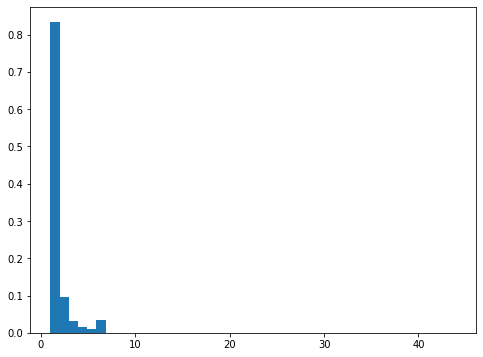

In [9]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
bv = ax.hist(dt.values,bins=44,density=True)

In [10]:
haci_data = haci_data.assign(dt=dt)

In [11]:
haci_data_length_filtered = haci_data[haci_data.dt >= 5]

## 2.3 Randfälle

Da im HACI-Algorithmus selbst schon eine Pufferung des Randes in der Raumdimension eingebaut ist, müssten wir eigentlich nur zeitliche Randfälle betrachten.

In [12]:
def range_filter(objprops, field_shape, 
                 time_edge = 12, 
                 space_edge = 30):

    '''
    Filters objects too close to bounds.

    Parameters:
        * objprops: pandas dataframe
            properties of the HACI objects
        * field_shape: tuple (time, rows, columns)
            shape of the filed the HACI objects have been derived from
        * time_edge: int, default=12
            minimum distance an object has to have from the time boundaries 
        * space_edge: int, default=30
            minimum distance an object has to be separated from the spatial boundaries
    Returns:
        * list with booleans indicating whether the criteria have been met
    '''


    ntime, nrow, ncol = field_shape

    # temporal filter
    m_time1 = (objprops.t0 > time_edge)
    m_time2 = (objprops.t1 < (ntime - time_edge))
    
    m_time_range = m_time1 & m_time2


    # Filtering based on Bounding Box
    
    # lines or rows
    m_lrange = (objprops.l00 > space_edge) &  (
        objprops.l01 < nrow -  space_edge)
    
    # columns
    m_crange = (objprops.c00 > space_edge) &  (
        objprops.c01 < ncol -  space_edge)

    
    # combination of all
    m_range = m_lrange & m_crange & m_time_range

    return m_range

In [13]:
range_filtered = range_filter(haci_data,(288,900,900),time_edge = 12, space_edge = 0)

In [15]:
haci_data = haci_data.assign(rf = range_filtered)

In [16]:
haci_length = len(haci_data.id)
print("HACI-Fallanzahl: {}".format(haci_length))

HACI-Fallanzahl: 7915719


In [17]:
print("Fallzahl zu nahe am Rand: {:.2f} %\nRest: {:.2f} % ".format(100 * (len(haci_data[haci_data.rf==False].rf) / haci_length),
                                                           100 * (len(haci_data[haci_data.rf==True].rf) / haci_length)))

Fallzahl zu nahe am Rand: 7.67 %
Rest: 92.33 % 


Die Randfälle machen nur einen Teil von ca. 8&thinsp;% der gesamten HACI-Fälle aus.

## 2.4 Startfläche

In [18]:
area0 = (haci_data.l01 - haci_data.l00) * (haci_data.c01 - haci_data.c00)
area_max = (haci_data.l1 - haci_data.l0) * (haci_data.c1 - haci_data.c0)

In [19]:
haci_data = haci_data.assign(area0 = area0)
haci_data = haci_data.assign(area_max = area_max)

In [20]:
haci_data.area0.describe(percentiles=[0.25,0.5,0.75,0.8,0.85,0.9,.91,.92,.93,.94,.95,.96,.97,.98,.99])

count    7.915719e+06
mean     3.535766e+00
std      1.364849e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
80%      2.000000e+00
85%      3.000000e+00
90%      4.000000e+00
91%      4.000000e+00
92%      4.000000e+00
93%      6.000000e+00
94%      6.000000e+00
95%      6.000000e+00
96%      8.000000e+00
97%      9.000000e+00
98%      1.200000e+01
99%      2.000000e+01
max      1.177300e+05
Name: area0, dtype: float64

Text(0, 0.5, 'Anzahl')

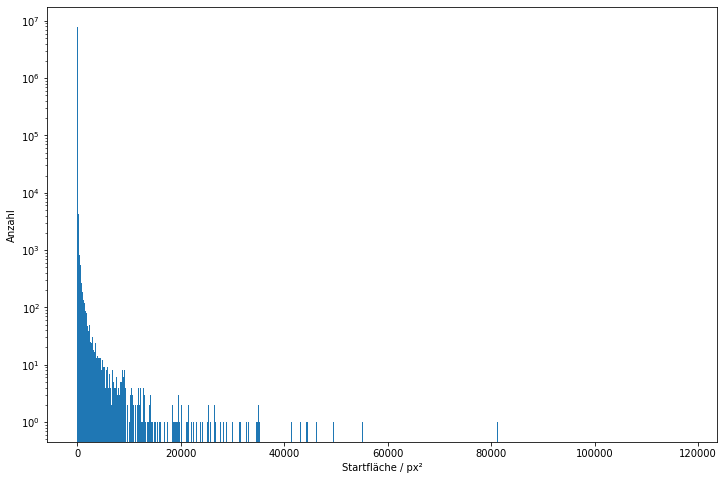

In [21]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
H,b,v = ax.hist(haci_data.area0.values, bins=1000)
plt.yscale("log")
ax.set_xlabel(u"Startfläche / px²")
ax.set_ylabel("Anzahl")

Der 99&thinsp;% der HACI-Objekte hat zum Startzeitpunkt eine 35&thinsp;dBZ-Fläche, die kleiner oder gleich 2&thinsp;px<sup>2</sup> ist. Der Mittelwert beträgt 4&thinsp;px<sup>2</sup> und der Median sogar nur 1&thinsp;px<sup>2</sup>.

In [22]:
haci_data[haci_data.dt>=5].area0.describe(percentiles=[0.25,0.5,0.75,0.8,0.85,0.9,.91,.92,.93,.94,.95,.96,.97,.98,.99])

count    352076.000000
mean         34.745751
std         633.305887
min           1.000000
25%           1.000000
50%           2.000000
75%           8.000000
80%          10.000000
85%          15.000000
90%          20.000000
91%          24.000000
92%          25.000000
93%          30.000000
94%          35.000000
95%          40.000000
96%          50.000000
97%          72.000000
98%         132.000000
99%         374.000000
max      117730.000000
Name: area0, dtype: float64

Bei den HACI-Objekte, die länger als 30&thinsp;min anhalten, beträgt der Median 2&thinsp;px<sup>2</sup> und der Mittelwert 35&thinsp;px. Die länger andauernden Objekte tendieren also erwartungsgemäß dazu schon zu Beginn größere Niederschlagsflächen zu haben.

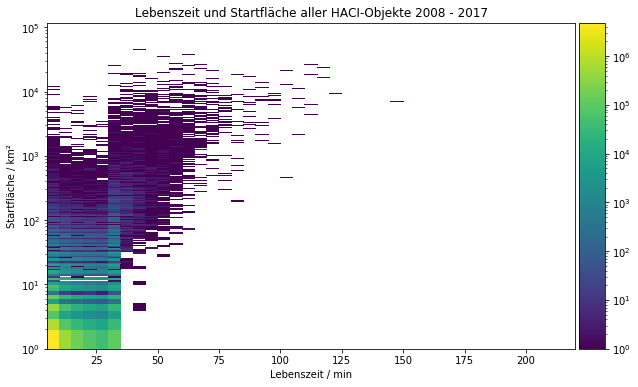

In [23]:
H,xedges,yedges = np.histogram2d(haci_data.dt.values*5,
                                 haci_data.area0.values,bins=(np.max(haci_data.dt.values)-1,
                                                              haci_data.area0.max()))
H = H.T
X, Y = np.meshgrid(xedges, yedges)
fig,ax = plt.subplots(1,1,figsize=(10,6))
p = ax.pcolormesh(X,Y,H, norm=mcolors.LogNorm())
ax.set_xlabel("Lebenszeit / min")
ax.set_ylabel(u"Startfläche / km²")
ax.set_title("Lebenszeit und Startfläche aller HACI-Objekte 2008 - 2017")
plt.yscale("log")
fc.colourbar(p)

In [24]:
haci_length_filtered = haci_data[haci_data.dt >= 5]

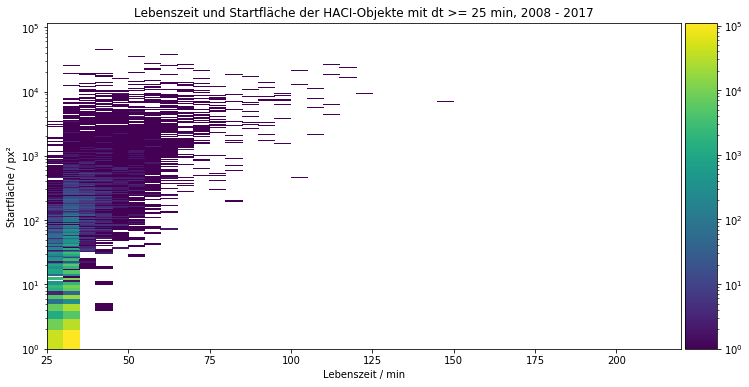

In [25]:
H,xedges,yedges = np.histogram2d(haci_length_filtered.dt.values*5,
                                 haci_length_filtered.area0.values,
                                 bins=((np.max(haci_length_filtered.dt.values) - np.min(haci_length_filtered.dt.values)),
                                       haci_data.area0.max()))
H = H.T
X, Y = np.meshgrid(xedges, yedges)
fig,ax = plt.subplots(1,1,figsize=(12,6))
p = ax.pcolormesh(X,Y,H, norm=mcolors.LogNorm())
ax.set_xlabel("Lebenszeit / min")
ax.set_ylabel(u"Startfläche / px²")
ax.set_title("Lebenszeit und Startfläche der HACI-Objekte mit dt >= 25 min, 2008 - 2017")
plt.yscale("log")
fc.colourbar(p)

Diese Tendenz zeigt sich auch für den gesamten Datensatz, obwohl es auch Objekte mit kurzer Lebenszeit und großer Startfläche und ungleich mehr langlebige Objekte mit kleiner Startfläche gibt. Dabei scheint die Tendenz vor allem für Objekte mit einer Lebenszeit von 35&thinsp;min und mehr ausgeprägter zu sein. Diese Objekte machen nur ca. 5&thinsp;% aller HACI-Objekte aus, sind wahrscheinlich aber die konvektiven Objekte. Bei der Maximalfläche sollte diese Tendenz ausgeprägter sein.

## 2.5 Maximalfläche

In [26]:
haci_data.area_max.describe(percentiles=[0.25,0.5,0.75,0.8,0.85,0.9,.91,.92,.93,.94,.95,.96,.97,.98,.99])

count    7.915719e+06
mean     1.784924e+01
std      4.399156e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
80%      3.000000e+00
85%      4.000000e+00
90%      6.000000e+00
91%      6.000000e+00
92%      9.000000e+00
93%      9.000000e+00
94%      1.200000e+01
95%      1.600000e+01
96%      2.500000e+01
97%      4.200000e+01
98%      8.400000e+01
99%      1.980000e+02
max      1.895400e+05
Name: area_max, dtype: float64

Text(0, 0.5, 'Anzahl')

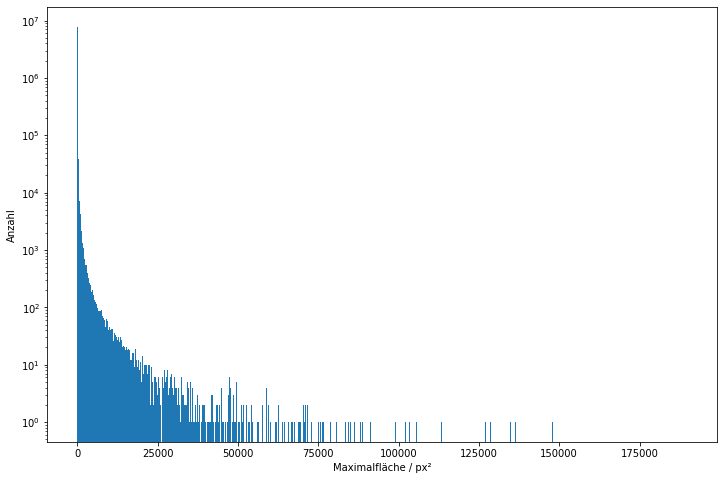

In [27]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
H,b,v = ax.hist(haci_data.area_max.values, bins=1000)
#plt.xscale("log")
plt.yscale("log")
ax.set_xlabel(u"Maximalfläche / px²")
ax.set_ylabel("Anzahl")

Für mehr als 50&thinsp;% der Objekte beträgt die Maximalfläche nur 1&thinsp;px<sup>2</sup>, d.h. sie wachsen nicht. Weitere 25&thinsp;% wachsen um 1&thinsp;px<sup>2</sup>. Die Objekte, die eine Maximalfläche mehr als 10&thinsp;px<sup>2</sup> erreichen machen nur ca. 4&thinsp;% der Fälle aus und die, die mehr als 100&thinsp;px<sup>2</sup> erreichen weniger als 2&thinsp;%. Wirklich konvektive Fälle sind im Datensatz also vergleichsweise selten.

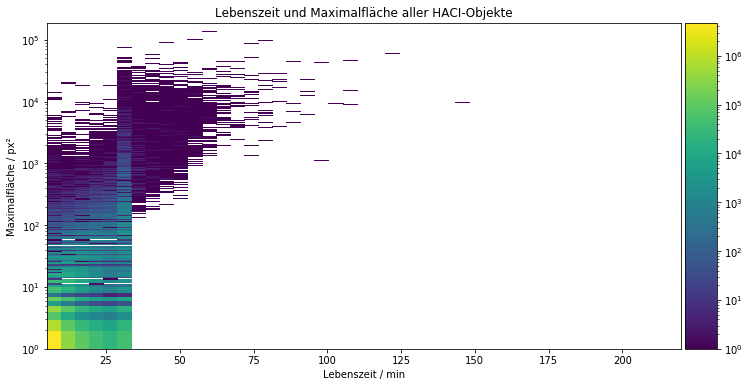

In [28]:
H,xedges,yedges = np.histogram2d(haci_data.dt*5,
                                 haci_data.area_max,bins=(45,haci_data.area_max.max()))
H = H.T
X, Y = np.meshgrid(xedges, yedges)

fig,ax = plt.subplots(1,1,figsize=(12,6))
p = ax.pcolormesh(X,Y,H, norm=mcolors.LogNorm())
ax.set_xlabel("Lebenszeit / min")
ax.set_ylabel(u"Maximalfläche / px²")
ax.set_title("Lebenszeit und Maximalfläche aller HACI-Objekte")
plt.yscale("log")
fc.colourbar(p)

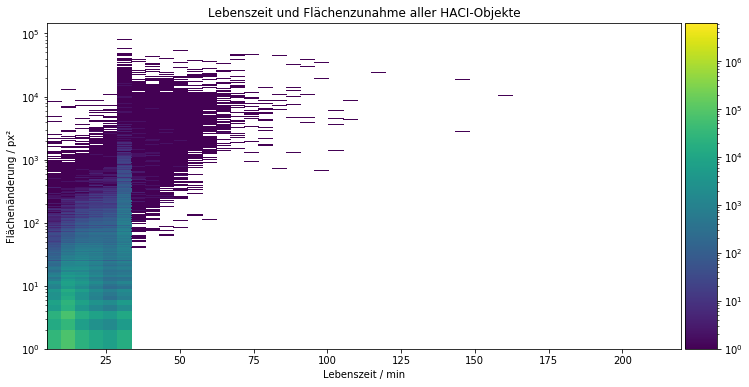

In [29]:
H,xedges,yedges = np.histogram2d(haci_data.dt*5,
                                 haci_data.area_max - haci_data.area0,bins=(45,
                                                                            np.max(haci_data.area_max - haci_data.area0)))
H = H.T
X, Y = np.meshgrid(xedges, yedges)
fig,ax = plt.subplots(1,1,figsize=(12,6))
p = ax.pcolormesh(X,Y,H, norm=mcolors.LogNorm())
ax.set_xlabel("Lebenszeit / min")
ax.set_ylabel(u"Flächenänderung / px²")
ax.set_title("Lebenszeit und Flächenzunahme aller HACI-Objekte")
plt.yscale("log")
ax.set_ylim(1,np.max(haci_data.area_max - haci_data.area0))
fc.colourbar(p)

Wie erwartet neigen die Objekte mit längerer Lebenszeit dazu eine größere Fläche zu haben. Insbesondere diejenigen mit einer Lebenszeit von 35&thinsp;min und mehr, allerdings ist die Streuung relativ breit. Die Objekte mit einer Lebenszeit von mehr als 35&thinsp;min könnten konvektive Objekte sein. Aber es gibt auch Objekte unter ihnen, deren Startfläche bereits sehr groß ist. Das sind wahrscheinlich eher Fronten oder stratiforme Niederschläge.

In [30]:
bins = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]

In [31]:
bins = [i for i in np.arange(1,11)] + \
       [i for i in np.arange(10,100,10)] + \
       [i for i in np.arange(100,1000,100)] + \
       [i for i in np.arange(1000,11000,1000)] +\
       [i for i in np.arange(100000,100000,10000)]

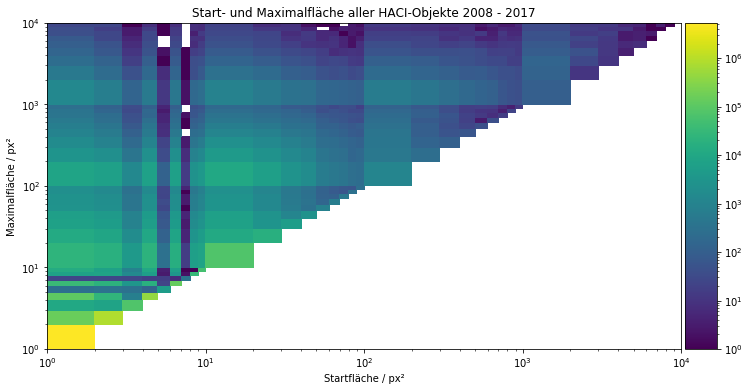

In [32]:
H,xedges,yedges = np.histogram2d(haci_data.area0,
                                 haci_data.area_max,
                                 bins=bins)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
fig,ax = plt.subplots(1,1,figsize=(12,6))
p = ax.pcolormesh(X,Y,H, norm=mcolors.LogNorm())
ax.set_xlabel(u"Startfläche / px²")
ax.set_ylabel(u"Maximalfläche / px²")
ax.set_title("Start- und Maximalfläche aller HACI-Objekte 2008 - 2017")
plt.yscale("log")
plt.xscale("log")
fc.colourbar(p)

Zwischen Start- und Maximalfläche gibt es keine klare Korrelation. Objekte mit größerer Startfläche erreichen prinizpiell zwar höhere Maximalflächen, aber sie wachsen meist nicht sehr viel. Es gibt ein Muster, dass Objekte mit 10&thinsp;px<sup>2</sup> Startfläche bevorzugt Maximalflächen von 100 oder 1000&thinsp;px<sup>2</sup> erreichen und ähnliches für Startflächen von 100 und 1000&thinsp;px<sup>2</sup>, aber das ist wahrscheinlich ein Artefakt der Gruppenauswahl für das 2d-Histogram.

## 2.5 Stärkerer Niederschlag in Feld mit schwächerem

In [33]:
from io_tools import radolan

In [35]:
plt.close("all")

In [36]:
def dbz_filter(objprops,lower_dbz_threshold=20,upper_dbz_threshold=35,min_area_ratio=None):
    """
    Calculates and compares the ratio of the area with more than the lower and more than the upper threshold

    Parameters:
        * objprops: pandas dataframe
            properties of the HACI objects
        * lower_dbz_threshold: int
            value of the surrounding areas
        * upper_dbz_threshold: int
            value of the areas of interest
        * min_area_ratio: float
            minimum ratio of the surrounding and interesting areas
    Returns:
        * list with booleans indicating whether the criteria have been met
    """
    from skimage import measure
    
    objprops['area_ratio'] = 0
    r = radolan.Radolan()
    
    rr = pd.DataFrame(index = objprops.index,columns=['area_ratio'])
    for i, obj in objprops.iterrows():
        date_t0 = "{}T{:02d}{:02d}".format(obj.date.replace("-",""),(obj.t0*5)//60, (obj.t0*5)%60)
        date_t0 = pd.Timestamp(date_t0)
        
        r.read(date_t0.to_pydatetime())
        
        cutout = r.data[obj.l0:obj.l1,obj.c0:obj.c1]
        
        pixel_20dbz = np.where(cutout>=lower_dbz_threshold)
        pixel_35dbz = np.where(cutout>=upper_dbz_threshold)
        
        ratio = float(len(pixel_35dbz[0])) / len(pixel_20dbz[0])
        
        rr.loc[i].area_ratio = ratio
    
    if min_area_ratio == None:
        return rr.area_ration
    else:
        return rr.area_ratio > min_area_ratio

In [39]:
years = [int(d[0:4]) for d in haci_data.date]

In [40]:
haci_data = haci_data.assign(year=years)

In [ ]:
area_ratio_20_35 = dbz_filter(haci_data[haci_data.year==2013],20,35)

## 3. Mögliche Schwellwerte

1. Radarreflektivitätsfaktor: Z&geq;&thinsp;35&thinsp;dBZ (Mecikalski, Haberlie)
2. Mindestlebenszeit: 
    - 35&thinsp;min: keine kleinen nicht wachsenden Objekte mehr, aber nur relativ wenige Fälle
    - 25&thinsp;min: mehr Fälle, aber viele kleine, nicht wachsende Objekte dabei
    - 30&thinsp;min: vielleicht guter Kompromiss
3. Startfläche: mindestens 10&thinsp;px<sup>2</sup>, um sehr kleine Objekte und maximal 200&thinsp;px<sup>2</sup> um zu große Objekte auszuschließen
4. Flächenzunahme: mindstens 100&thinsp;px<sup>2</sup>, um wirklich wachsende Objekte zu bekommen
5. Verhältnis 35- zu 20&thinsp;dBZ-Fläche: 0,3

In [52]:
n_all_cases = len(haci_data.t0.values)

In [43]:
dt = haci_data.t1 - haci_data.t0
haci_data = haci_data.assign(dt=dt)

In [76]:
area0 = (haci_data.l01 - haci_data.l00) * (haci_data.c01 - haci_data.c00)
area_max = (haci_data.l1 - haci_data.l0) * (haci_data.c1 - haci_data.c0)

In [77]:
haci_data = haci_data.assign(area0 = area0, area_max = area_max)

In [78]:
range_filtered = range_filter(haci_data,(288,900,900),time_edge = 12, space_edge = 0)
haci_data = haci_data.assign(rf = range_filtered)

In [79]:
n_range_filtered = len(haci_data[haci_data.rf==True])

In [80]:
n_range_filtered

7308202

In [81]:
haci_data_rf = haci_data[haci_data.rf==True]

In [82]:
haci_data_lf = haci_data_rf[haci_data_rf.dt >=6]
n_length_filtered = len(haci_data_lf.dt)

In [86]:
haci_a0_mnf = haci_data_lf[haci_data_lf.area0 >= 10]
haci_a0_mxf = haci_a0_mnf[haci_a0_mnf.area0 < 100]
haci_da_f = haci_a0_mxf[haci_a0_mxf.area_max - haci_a0_mxf.area0 > 100]

In [88]:
n_a0_mnf = len(haci_a0_mnf.area0)
n_a0_mxf = len(haci_a0_mxf.area0)
n_da_f = len(haci_a0_mxf.area0)

In [93]:
print(u"HACI-Fallzahlen:\n----------------\n\n2008 bis 2017 gesamt: {}\nnach Randfilterung : {}\nnach Längenfilterung: {}\nnach min. Mindestfläche: {}\nnach max. Mindestfläche: {}\nnach Flächenänderung: {}".format(n_all_cases,n_range_filtered,n_length_filtered,n_a0_mnf,n_a0_mxf,n_da_f))

HACI-Fallzahlen:
----------------

2008 bis 2017 gesamt: 7915719
nach Randfilterung : 7308202
nach Längenfilterung: 253644
nach min. Mindestfläche: 58335
nach max. Mindestfläche: 51060
nach Flächenänderung: 51060
